In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, parse_alphapose

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_intrinsic_mat_default()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

print(f'img_shape_xy: {img_shape_xy}')

img_shape_xy: (1280, 720)


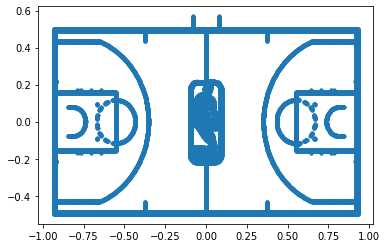

In [2]:
img = plt.imread(VID_ROOT+'/view_0/frame_00089.png')
img = (img*255/img.max()).astype(np.uint8)

court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)

mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))

X_w = model.calc_model_world_coordinates(DATA_ROOT)
plt.scatter(X_w[:, 0], X_w[:, 1], marker='.');plt.show()

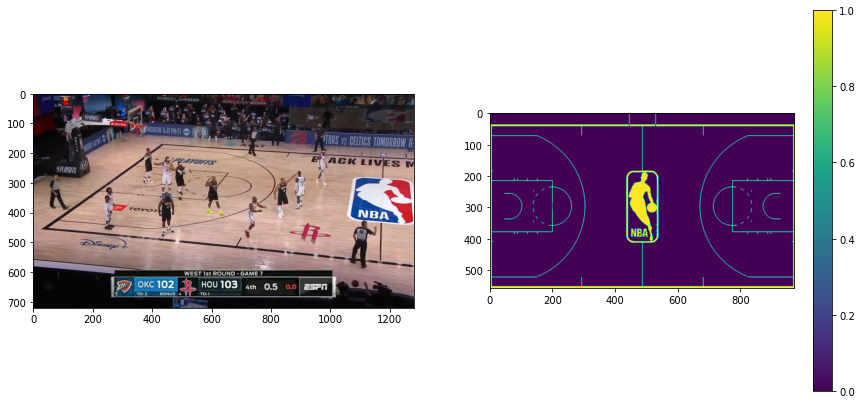

In [3]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(court_bin);plt.colorbar();plt.show()

In [4]:
import json
import numpy as np
with open('/home/akarshkumar0101/nba-3d-data/harden/init_views.json') as f:
    data = json.load(f)
data = np.array(data)
# keypoint correspondance data
# data has shape [view, {image/model}, 4, {x, y}]
print(data.shape)

(3, 2, 4, 2)


# Homography

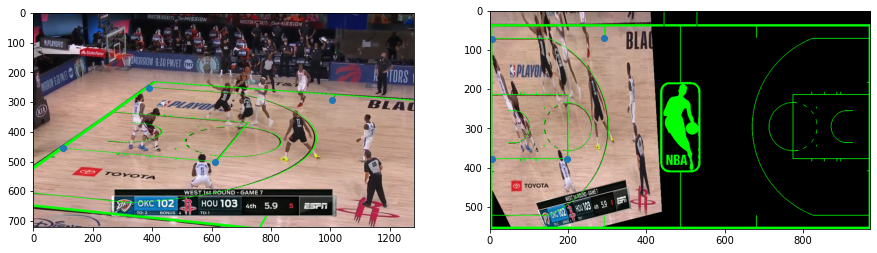

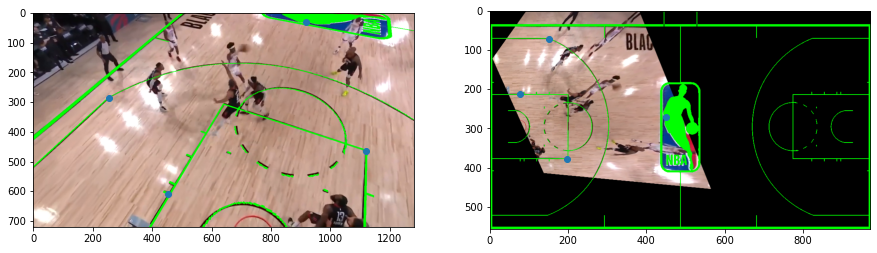

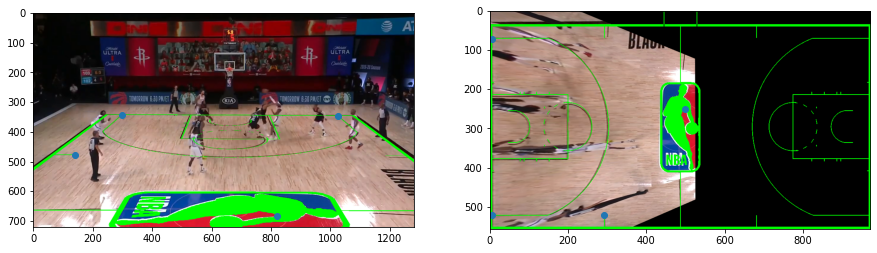

In [5]:
for view_idx in range(3):
    img = plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png')
    img = (img*255/img.max()).astype(np.uint8)
    src = data[view_idx, 0]
    dst = data[view_idx, 1]
    H, _ = cv2.findHomography(src, dst, )

    plt.figure(figsize=(15,7))
    plt.subplot(121)
    courtt = cv2.warpPerspective(court_img, H, dsize=img.shape[:2][::-1], flags=cv2.WARP_INVERSE_MAP)
    courtt = courtt[..., :3].mean(axis=-1)>180
    imgt = img.copy()
    imgt[courtt, :] = 0.
    imgt[courtt, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(src[:, 0], src[:, 1], marker='o')
    plt.imshow(imgt)
    
    plt.subplot(122)
    imgt = cv2.warpPerspective(img, H, dsize=court_img.shape[:2][::-1])
    imgt[court_bin, :] = 0.
    imgt[court_bin, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(dst[:, 0], dst[:, 1])
    plt.imshow(imgt)
    
    plt.show()
    

# Perspective N Point

In [6]:
def find_cv2_RT(f, X_i_kp, X_w_kp):
    mat_int = cam.apply_focus(f, uf_mat_int)[:, :3]
    
    retval, R, T = cv2.solvePnP(X_w_kp, X_i_kp, mat_int, np.zeros((4,1)), flags=cv2.SOLVEPNP_IPPE)
    R, _ = cv2.Rodrigues(R)
    # this returns R, T such that mat_int@(R@X_w+T) ~= X_i
    
    X_c_kp = (R@X_w_kp[..., None])+T
    X_i_kp_reproj = mat_int[:, :3]@X_c_kp
    X_i_kp_reproj = util.from_homo(X_i_kp_reproj[..., 0])
    
    return R, T, X_i_kp_reproj

def calc_dofs_cam_from_cv2_RT(R, T):
    dofs_cam = torch.zeros(7)
    dofs_cam[:3] = torch.from_numpy(-np.linalg.inv(R)@T[..., 0])
    dofs_cam[3:6] = util.so3_log_map(torch.from_numpy(np.linalg.inv(R)))
    dofs_cam[6] = np.log(f)
    return dofs_cam

dofs_cam = []
X_i_kp_reprojs = []
X_i_kps = []
for view_idx in range(3):
    fits = []
    fs = np.logspace(-2, 3, base=np.e, num=500)
    X_i_kp = data[view_idx, 0].astype(np.float64)
    X_m_kp = data[view_idx, 1].astype(np.float64)
    X_m_kp = np.concatenate([X_m_kp, np.zeros((len(X_m_kp), 1))], axis=-1)
    X_w_kp = util.from_homo((mat_model@util.to_homo(X_m_kp)[..., None])[..., 0])
    for f in fs:
        R, T, X_i_kp_reproj = find_cv2_RT(f, X_i_kp, X_w_kp)
        fit = np.linalg.norm(X_i_kp-X_i_kp_reproj, axis=-1).mean()
        fits.append(fit)
    
    f = fs[np.argmin(fits)]
    print(f'focal length: {f: 0.04f}, mean dist: {np.min(fits): 0.04f}')
    R, T, X_i_kp_reproj = find_cv2_RT(f, X_i_kp, X_w_kp)
    dofs_cam.append(calc_dofs_cam_from_cv2_RT(R, T))
    X_i_kps.append(X_i_kp)
    X_i_kp_reprojs.append(X_i_kp_reproj)
    
dofs_cam = torch.stack(dofs_cam)[:, None, :]

focal length:  4.3359, mean dist:  1.0037
focal length:  1.0662, mean dist:  0.8370
focal length:  2.3064, mean dist:  1.0630


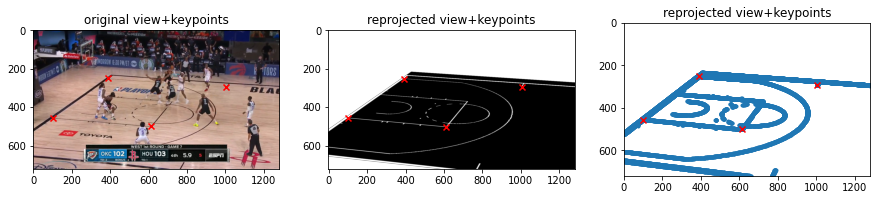

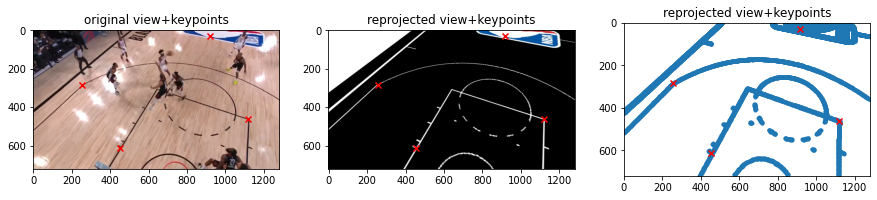

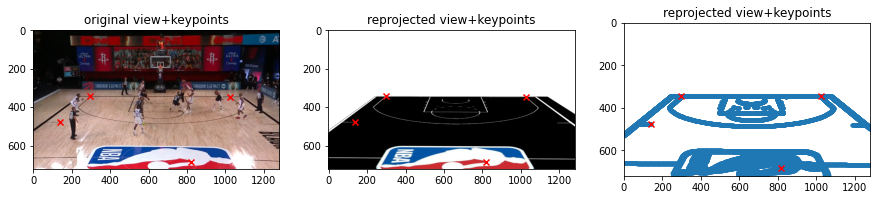

In [7]:
imgs = cam.calc_perspective_image(court_img, dofs_cam, mat_model, img_shape_xy)
for view_idx in range(3):
    draw.plt_figure_aspect_ratio((img_shape_xy[0]*3,img_shape_xy[1]), 15)
    plt.subplot(131)
    plt.imshow(plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png'))
    plt.scatter(X_i_kps[view_idx][:, 0], X_i_kps[view_idx][:, 1], marker='x', c='r')
    plt.title('original view+keypoints')
    
    plt.subplot(132)
    plt.imshow(imgs[view_idx, 0])
    plt.scatter(X_i_kp_reprojs[view_idx][:, 0], X_i_kp_reprojs[view_idx][:, 1], marker='x', c='r')
    plt.title('reprojected view+keypoints')
    
    plt.subplot(133)
    draw.show_cam_view(X_w, dofs_cam[view_idx, 0], img_shape_xy)
    plt.scatter(X_i_kp_reprojs[view_idx][:, 0], X_i_kp_reprojs[view_idx][:, 1], marker='x', c='r')
    plt.title('reprojected view+keypoints')
        
    plt.show()

In [8]:
np.save(VID_ROOT+'/dofs_cam_first_frame', dofs_cam.numpy())

In [9]:
kp, confs, scores, boxes = parse_alphapose.parse_alphapose(VID_ROOT, 90)

In [10]:
frame_idx = 0

In [11]:
vs = []
x0s = []
for view_idx in range(3):
    X_i_kp = np.array(kp[view_idx][frame_idx])
    mat_int = cam.get_intrinsic_mat_for_dofs_cam(dofs_cam[view_idx,frame_idx], img_shape_xy)
    mat_view = cam.get_mat_view(dofs_cam[view_idx, frame_idx])
    Rinv = np.linalg.inv(mat_view[:3, :3]) # camera to world

    X_c_kp_dir = np.linalg.inv(mat_int[:3, :3])@(util.to_homo(X_i_kp)[..., None])
    X_w_kp_dir = (Rinv @ X_c_kp_dir)[..., 0]
    X_base = dofs_cam[view_idx, frame_idx, :3].repeat(X_w_kp_dir.shape[:-1]+(1,)).numpy()
    x0s.append(X_base)
    vs.append(X_w_kp_dir)

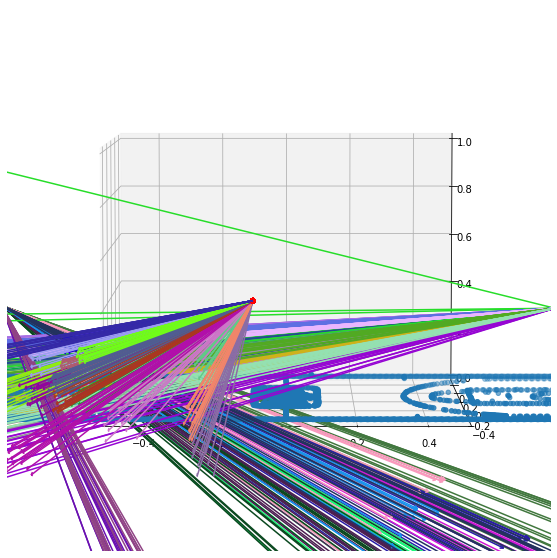

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='3d')
ax.scatter3D(X_w[::10, 0], X_w[::10, 1], X_w[::10, 2])
for view_idx, (vs_i, x0s_i) in enumerate(zip(vs, x0s)):
#     if view_idx != 0:continue
    colors = np.random.uniform(0, 1, size=(len(vs_i),3))
    for x0, v, color in zip(x0s_i, vs_i, colors):
        ax.scatter3D(x0[:, 0],x0[:, 1], x0[:, 2], c='r')
        ax.quiver3D(x0[:, 0],x0[:, 1], x0[:, 2],
                    v[:, 0], v[:, 1], v[:, 2],
                    length=3, arrow_length_ratio=0.01, color=color)
    
ax.set_xlim(-.5, .5);ax.set_ylim(-.5, .5);ax.set_zlim(0,1)
# ax.set_xlim(-2, 2);ax.set_ylim(-2, 2);ax.set_zlim(0,4)
ax.view_init(5, 270)

In [47]:
def calc_skew(x0, v0, x1, v1):
    vd = np.cross(v0, v1, axis=-1)
    # normalize vd
    vd = vd/np.linalg.norm(vd, axis=-1, keepdims=True)
    A = np.stack([v0, -v1, vd], axis=-1)
    b = (x1-x0)[..., None]
    t = np.linalg.solve(A, b)
    t0, t1, td = t[..., 0, :], t[..., 1, :], t[..., 2, :]
    return t0, t1, td, vd

scores = np.zeros((len(x0s[0]),len(x0s[2])))
pmids = np.zeros((len(x0s[0]),len(x0s[2]), 17, 3))
for person_idx0, (x0, v0) in enumerate(zip(x0s[0][:], vs[0][:])):
    for person_idx1, (x1, v1) in enumerate(zip(x0s[2][:], vs[2][:])):
        t0, t1, td, vd = calc_skew(x0, v0, x1, v1)
        p0 = x0+v0*t0
        p1 = x1+v1*t1
        pmid = (p0+p1)/2
        d = np.linalg.norm(p0-p1, axis=-1)
#         score = d.mean()
        score = np.sort(d)[:10].mean()
        
        scores[person_idx0, person_idx1] = score
        pmids[person_idx0, person_idx1] = pmid


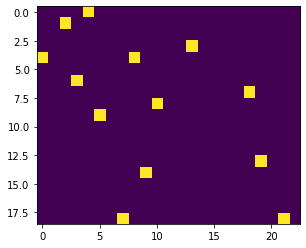

In [51]:
plt.imshow(scores<0.003)

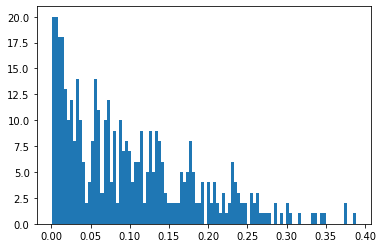

In [52]:
plt.hist(scores.flatten(), bins=100);

In [53]:
# view_idx0, view_idx1 = np.unravel_index(scores.argmin(), scores.shape)
view_idx0, view_idx1 = np.where(scores<0.003)
pmid = pmids[view_idx0, view_idx1]

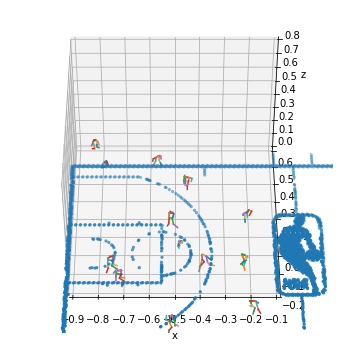

In [54]:
%matplotlib inline

plt.figure(figsize=(6,6))
ax = plt.subplot(projection='3d')
draw.draw_people(pmid, ax)
ax.set_xlabel('x');ax.set_ylabel('y');ax.set_zlabel('z')
ax.set_xlim(-0.9, -.1);ax.set_ylim(-.2, .6);ax.set_zlim(0,.8)
ax.scatter(*X_w[::10].swapaxes(0,1), marker='.')
ax.view_init(45, -90)
plt.show()

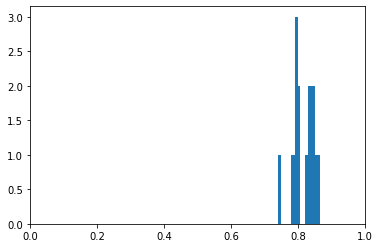

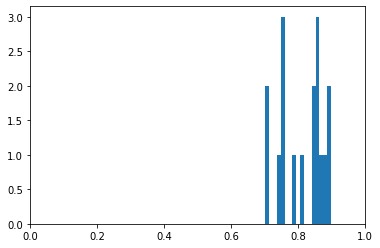

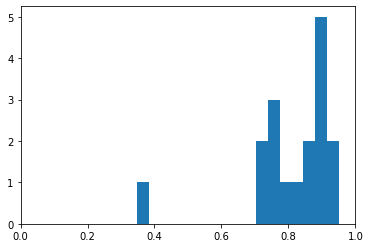

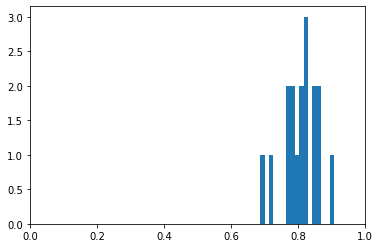

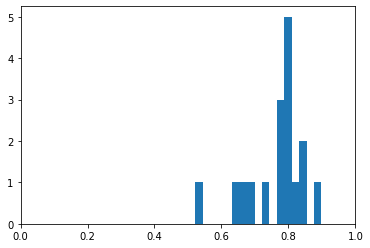

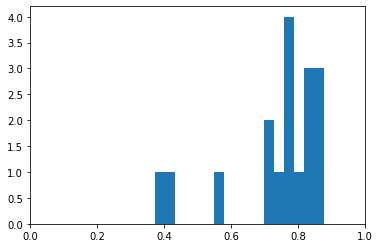

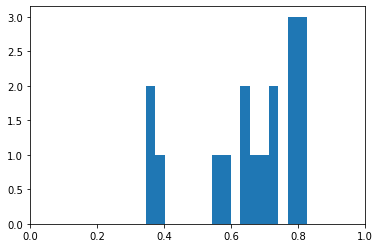

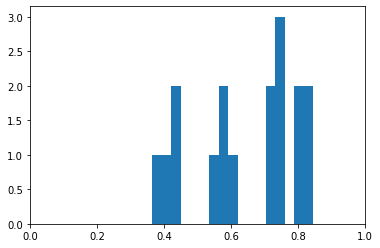

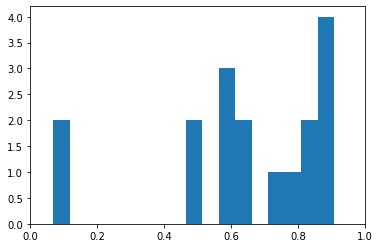

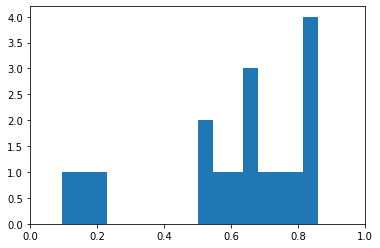

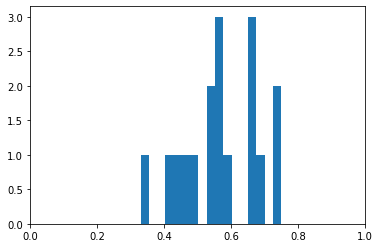

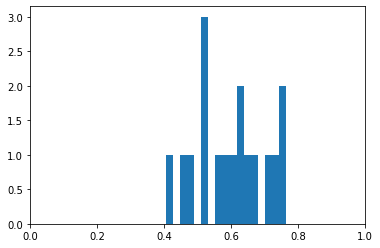

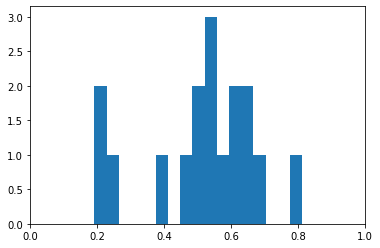

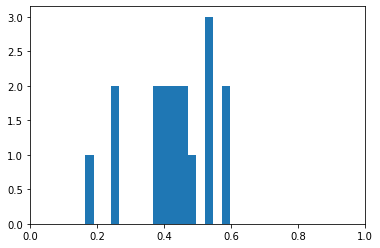

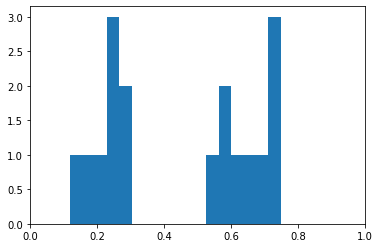

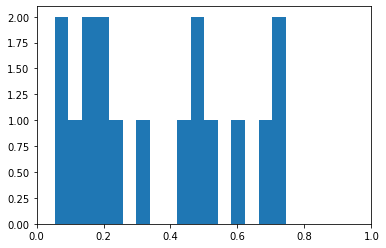

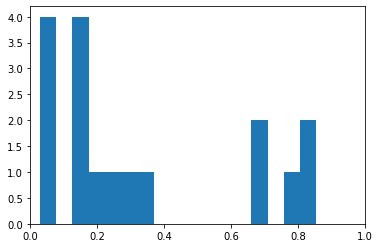

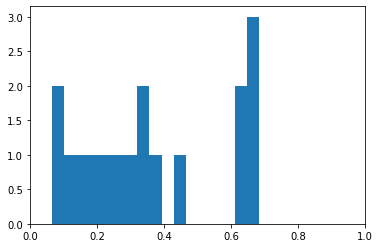

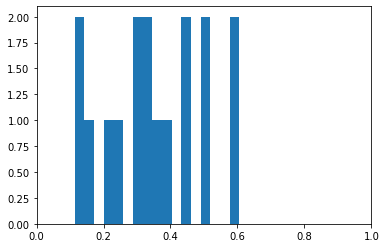

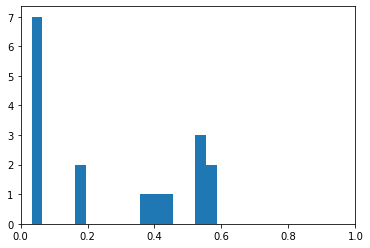

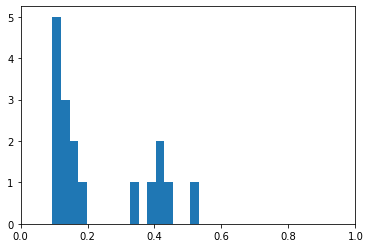

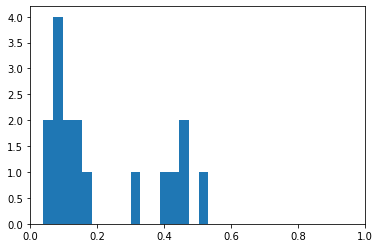

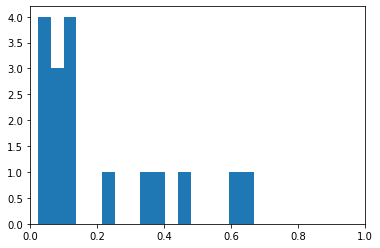

In [63]:
for p in confs[2][0]:
    plt.hist(p, bins=17)
    plt.xlim(0, 1)
    plt.show()

s[3,1] = [3x4]@[4x4]@[4,1]

s[3,1] = [3x4]@[4x4]@[4,1]

In [187]:
util.from_homo((np.linalg.inv(H)@util.to_homo(X_m_kp[:, :2])[..., None])[..., 0])

array([[ 298.,  344.],
       [ 139.,  478.],
       [1024.,  347.],
       [ 821.,  683.]])

In [145]:
mat_view = np.eye(4)
mat_view[:3, :3] = R
mat_view[:3, 3] = T[:, 0]

(mat_int@mat_view[:3, :])[:, [0, 1, 3]]



array([[-644.64542457, 1467.88421554,  566.31240396],
       [ -40.47394177,   -0.15371713,  570.27549247],
       [  -0.97740884,   -0.01259956,    0.85706268]])

In [158]:
X_i_kp

array([[ 298.,  344.],
       [ 139.,  478.],
       [1024.,  347.],
       [ 821.,  683.]])

In [174]:
util.from_homo((mat_int@((mat_view@util.to_homo(X_w_kp)[..., None])[..., :3, :]))[..., 0])

array([[ 298.11199174,  344.33345038],
       [ 139.44246215,  477.31734649],
       [1024.41284181,  346.39874838],
       [ 819.23891277,  684.56735158]])

In [189]:
np.linalg.inv(H)

array([[   0.078819  ,    0.18219962, -128.97193257],
       [   0.00463221,    0.00122189,  -39.29708117],
       [   0.0001194 ,    0.00000137,   -0.11362544]])

In [194]:
mat_int@mat_view[:3, [0, 1, 3]]

array([[-644.64542457, 1467.88421554,  566.31240396],
       [ -40.47394177,   -0.15371713,  570.27549247],
       [  -0.97740884,   -0.01259956,    0.85706268]])